# Лабораторная работа №2 по дисциплине Математические пакеты.
## Практическое применение дискретного преобразования Фурье с использованием библиотек Python для анализа речевых сигналов.
### Выполнил: Хотяков Евгений, гр. 9383

## Цель работы:
<p>Практическое применение дискретного преобразования Фурье c использованием библиотек Python для анализа речевых сигналов.</p>

### Задачи лабораторной работы:
<ol>
    <li>Используя ДПФ построить траекторию основного тона (F0) на записи своего голоса.</li>
    <li>Используя ДПФ построить траектории второй, третьей и четвертой формантных частот на записи своего голоса
    <li>Построить сонограмму по записи своего голоса.</li>
</ol>

## Основные теоретические положения

### Частота основного тона и форманты
#### Основной тон
Частотой основного тона (F0) называют частоту вибрации голосовых связок. У каждого говорящего базовая частота основного тона индивидуальна и обусловлена особенностямистроения гортани. Частота основного тона различна для мужских (примерный диапазон: 80− 200 Hz) и женских (примерный диапазон: 160− 350 Hz) голосов.

#### Форманты
Акустические резонансы в голосовом тракте создают пики в огибающей спектра звука. Такие пики называются формантами. Частота основного тона является первой формантой, далее идут вторая, третья и четвертая форматны: F1, F2, F3. Амплитуда каждой последующей форманты ниже, чем предыдущей, а их частоты примерно равны частоте основного тона умноженного на целое число: F1 ≈ 2F0, F2 ≈ 3F0, F3 ≈ 4F0.

### Построение F0,F1,F2,F3. Начальные данные
Пусть частота дискретизации сигнала — $F_{d}$ $H_{z}$.
Выберем $N$ — размерность ДПФ (для использования быстрого алгоритма FFT $N = 2^n$ — степень двойки). Рекомендованные значения 1024, 2048 или 4096. Для перевода частоты $f_{i}$ в отсчет амплитудного спектра $n_{i}$ используем формулу: $n_{i} = \begin{bmatrix} \frac{f_{i}}{S_{r}} \end{bmatrix}$, где $S_{r} = \begin{bmatrix} \frac{F_{d}}{N} \end{bmatrix}$ − текущее спектральное разрешение.

Пусть диапозон основного тона для нашего голоса $[f_{l},f_{u}]$ или в отсчетах спектра $[n_{l}, n_{u}]$, где, согласно (1): $n_{l} = \begin{bmatrix} \frac{f_{l}}{S_{r}} \end{bmatrix}$, $n_{u} = \begin{bmatrix} \frac{f_{u}}{S_{r}} \end{bmatrix}$

#### Алгоритм построения F0,F1,F2,F3
Разбиваем сигнал на отрезки длиной N . Рекомендуется работа с перекрытиями: сдвиг для следующего интервала 0.5N, 0.25N.
На каждом отрезке сигнал предварительно умножаем на окно (Хеннига (Ханна), Хемминга, Блекмана-Харриса, Кайзера-Бесселя и т.п., затем вычисляем ДПФ и на его основе амплитудный спектр в интервале (0,N/2).

Ищем существенное максимальное значение амплитудного спектра на отрезке $[n_{l},n_{u}]$ — это будет частота основного тона F0 (точка амплитудного спектра $n_{0}$). Если такого максимума нет — это интервал паузы или не вокализованного звука. Полагаем F0 = 0.

В окрестности точки $2n_{0}$ ищем максимальное значение амплитудного спектра, которое должно быть существенно меньше значения в точке $n_{0}$. Если это предположение верно, то мы нашли частоту второй форманты F1. Если нет — второй форманты у сигнала на этом отрезке нет. Полагаем F1 = 0.

Далее проводим поиск для третьей форманты в окрестности точки $3n_{0}$. Повторяем процесс для четвертой форманты в окрестности точки $4n_{0}$.

In [204]:
from scipy.io import wavfile
from scipy import signal
from scipy.fft import fft
import numpy as np
import matplotlib.pyplot as plt

Объявляем постоянные значения

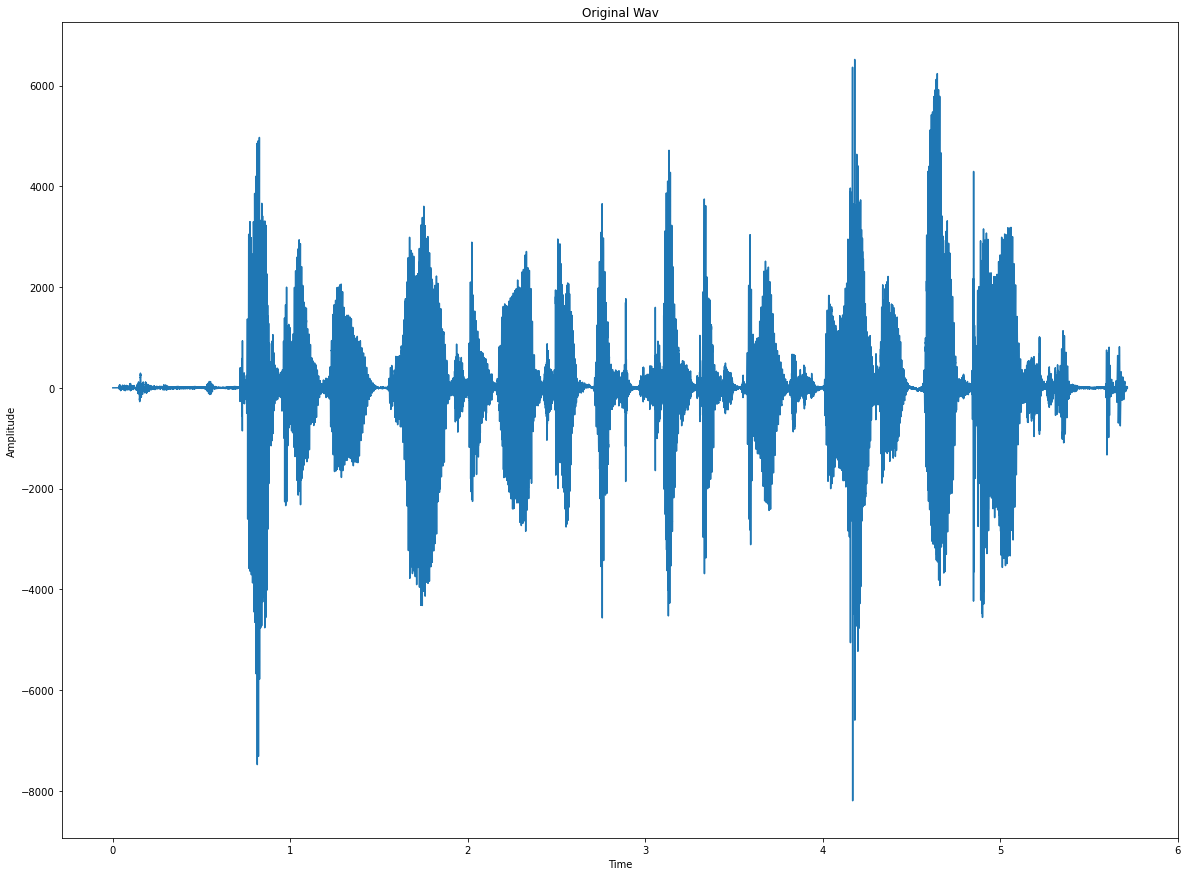

In [205]:
samplerate, f = wavfile.read("record.wav")
Fd = 16000
N = 1024
Sr = round(Fd / N)
nl = 80 // Sr
nu = 200 // Sr
audio_time = len(f) / samplerate
x = np.linspace(0, audio_time, len(f))

plt.plot(x, f)
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.title("Original Wav")
plt.show()

Строим амплитудный спектр

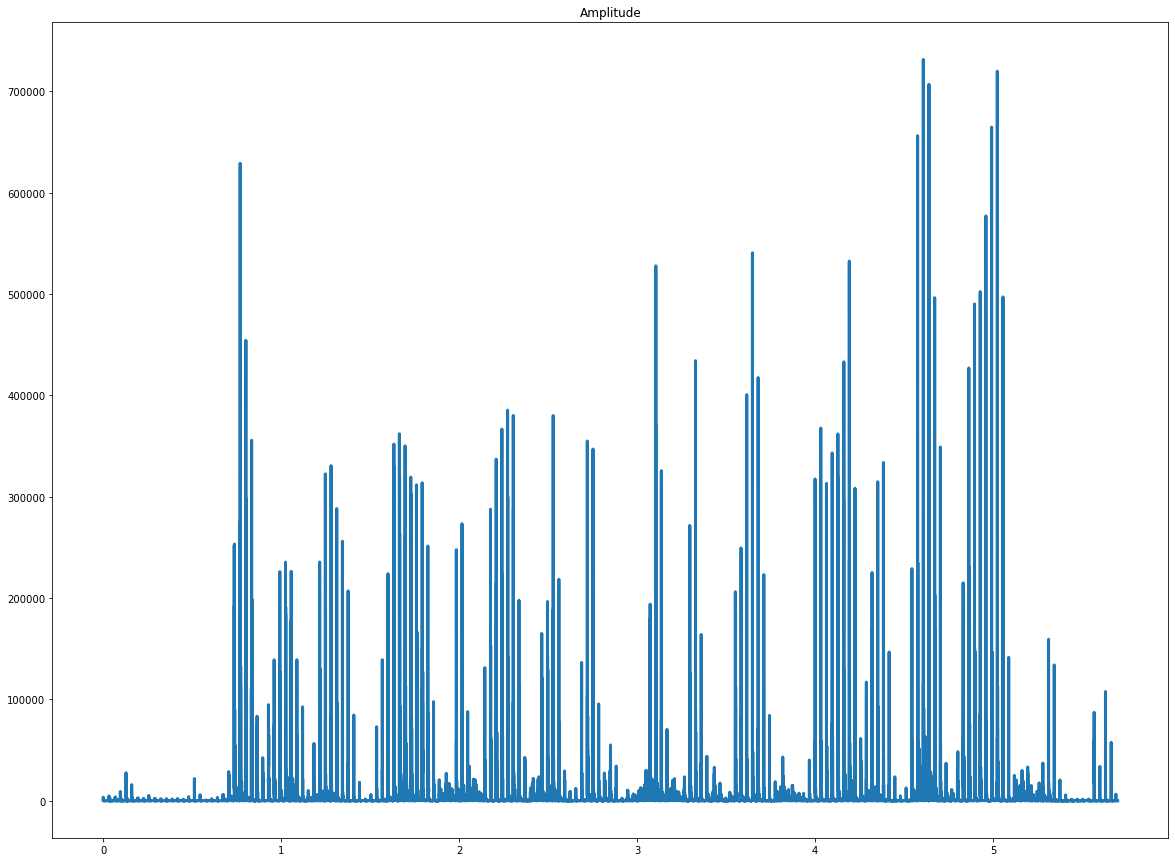

In [206]:
amplitude = []
for i in range(0, len(f), N//2):
    steps = min(N, len(f)-i)
    hm = np.hamming(steps)
    newSig = []
    for j in range(steps):
        newSig.append(f[i + j] * hm[j])
    newSig = fft(newSig)[0:steps//2]
    amplitude.append(abs(newSig))
fullAmplitude = []
for i in amplitude:
    fullAmplitude.extend(i)

audio_time = len(fullAmplitude) / samplerate
x = np.linspace(0, audio_time, len(fullAmplitude))
plt.title('Amplitude')
plt.plot(x, fullAmplitude, linewidth = 3)
plt.show()

Строим F0 - траектория основного тона

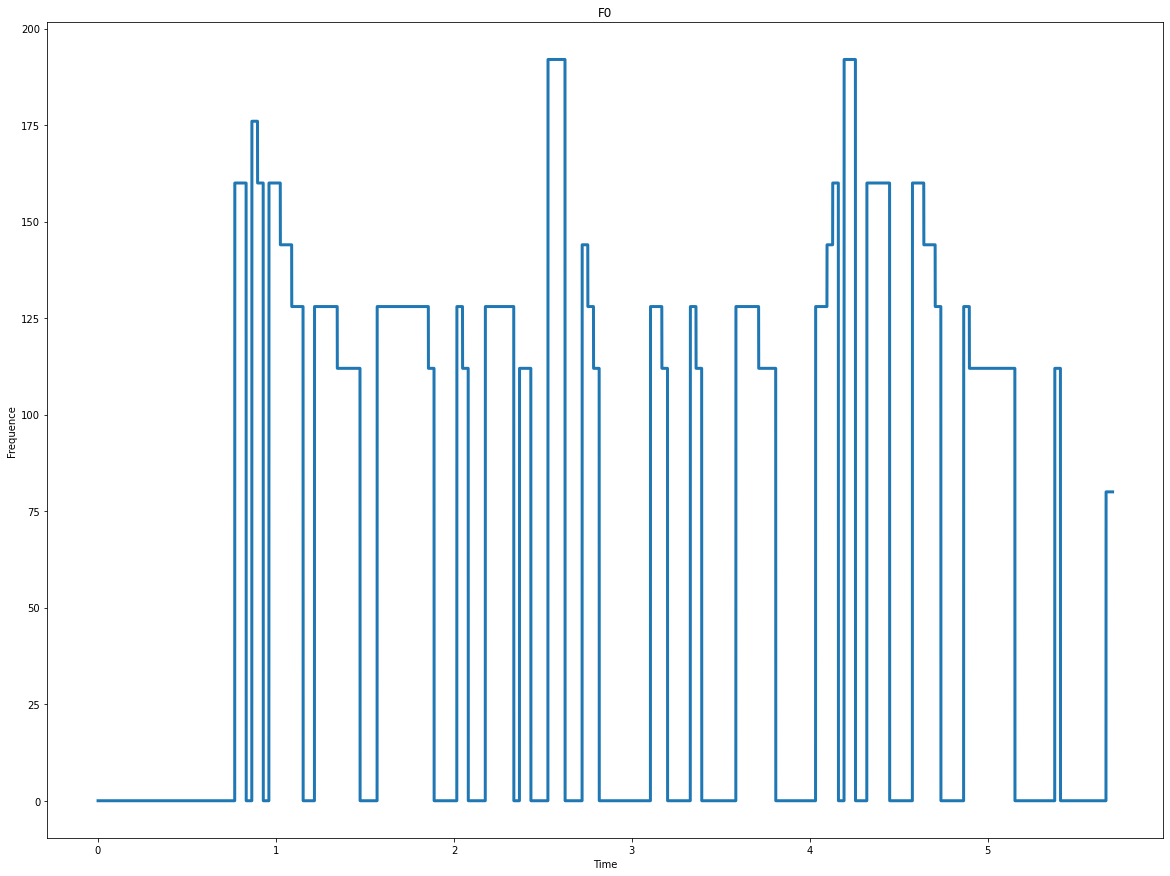

In [207]:
F0 = []
frequences = []
for i in range(len(amplitude)):
    array = amplitude[i][nl:nu+1]
    indexOfMax = np.argmax(array)
    meanValue = np.mean(array)
    if(array[indexOfMax] > 3*meanValue):
        n0 = nl + indexOfMax
    else:
        n0 = 0
    frequences.append(n0)
    for j in range(len(amplitude[i])):
        F0.append(n0 * Sr)
    
audio_time = len(F0) / samplerate
x = np.linspace(0, audio_time, len(F0))

plt.title('F0')
plt.ylabel("Frequence")
plt.xlabel("Time")
plt.plot(x, F0, linewidth = 3)
plt.show()

Строим F1, F2 и F3

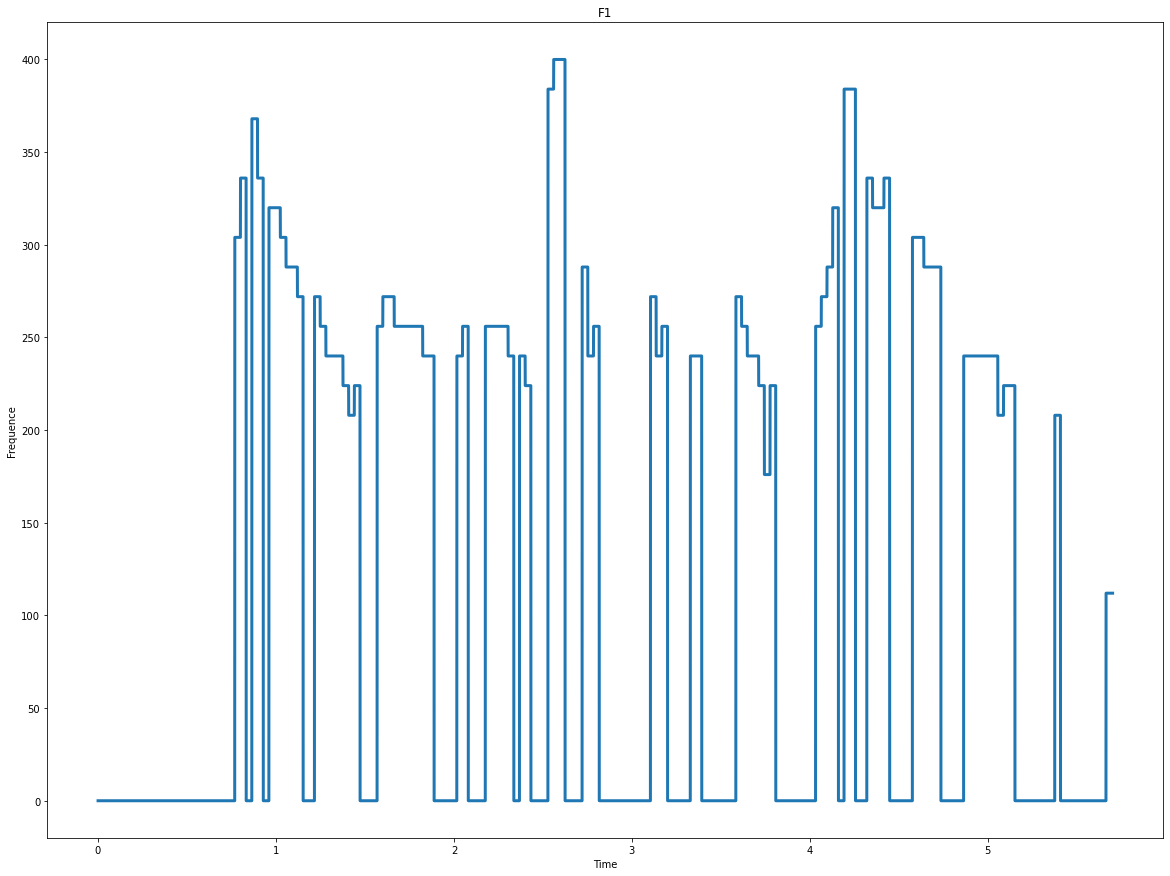

In [209]:
F1 = []
segmentLength = (nu - nl) // 2

for i in range(len(amplitude)):
    if(frequences[i] != 0):
        nl1 = 2 * frequences[i] - segmentLength
        nu1 = 2 * frequences[i] + segmentLength
        array = amplitude[i][nl1:nu1]
        indexOfMax = np.argmax(array)
        nValue = amplitude[i][frequences[i]]
        if(array[indexOfMax] < 3*nValue):
            n0 = nl1 + indexOfMax
        else:
            n0 = 0
        for j in range(len(amplitude[i])):
            F1.append(n0 * Sr)
    else:
        for j in range(len(amplitude[i])):
            F1.append(0)
    
audio_time = len(F1) / samplerate
x = np.linspace(0, audio_time, len(F1))

plt.title('F1')
plt.ylabel("Frequence")
plt.xlabel("Time")
plt.plot(x, F1, linewidth = 3)
plt.show()

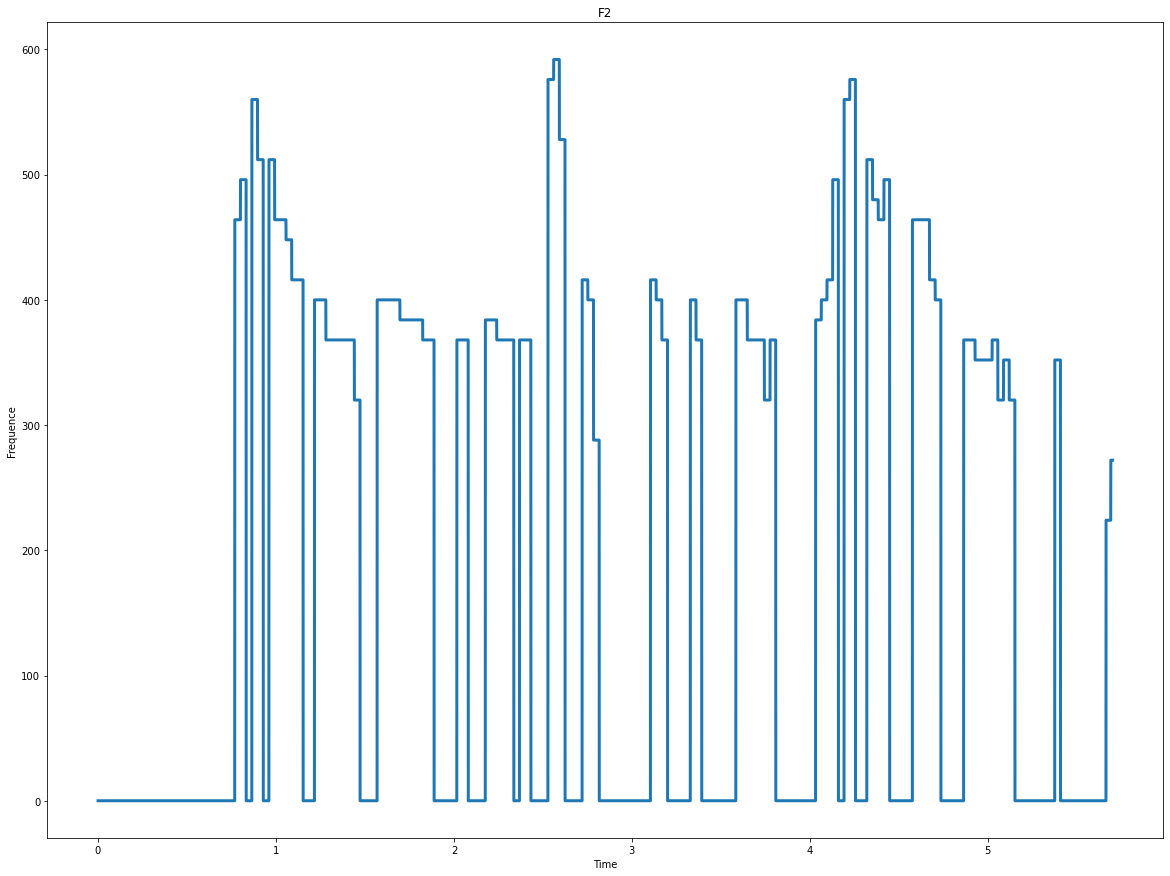

In [210]:
F2 = []

for i in range(len(amplitude)):
    if(frequences[i] != 0):
        nl1 = 3 * frequences[i] - segmentLength
        nu1 = 3 * frequences[i] + segmentLength
        array = amplitude[i][nl1:nu1]
        indexOfMax = np.argmax(array)
        nValue = amplitude[i][frequences[i]]
        if(array[indexOfMax] < 3*nValue):
            n0 = nl1 + indexOfMax
        else:
            n0 = 0
        for j in range(len(amplitude[i])):
            F2.append(n0 * Sr)
    else:
        for j in range(len(amplitude[i])):
            F2.append(0)
    
audio_time = len(F2) / samplerate
x = np.linspace(0, audio_time, len(F2))

plt.title('F2')
plt.ylabel("Frequence")
plt.xlabel("Time")
plt.plot(x, F2, linewidth = 3)
plt.show()

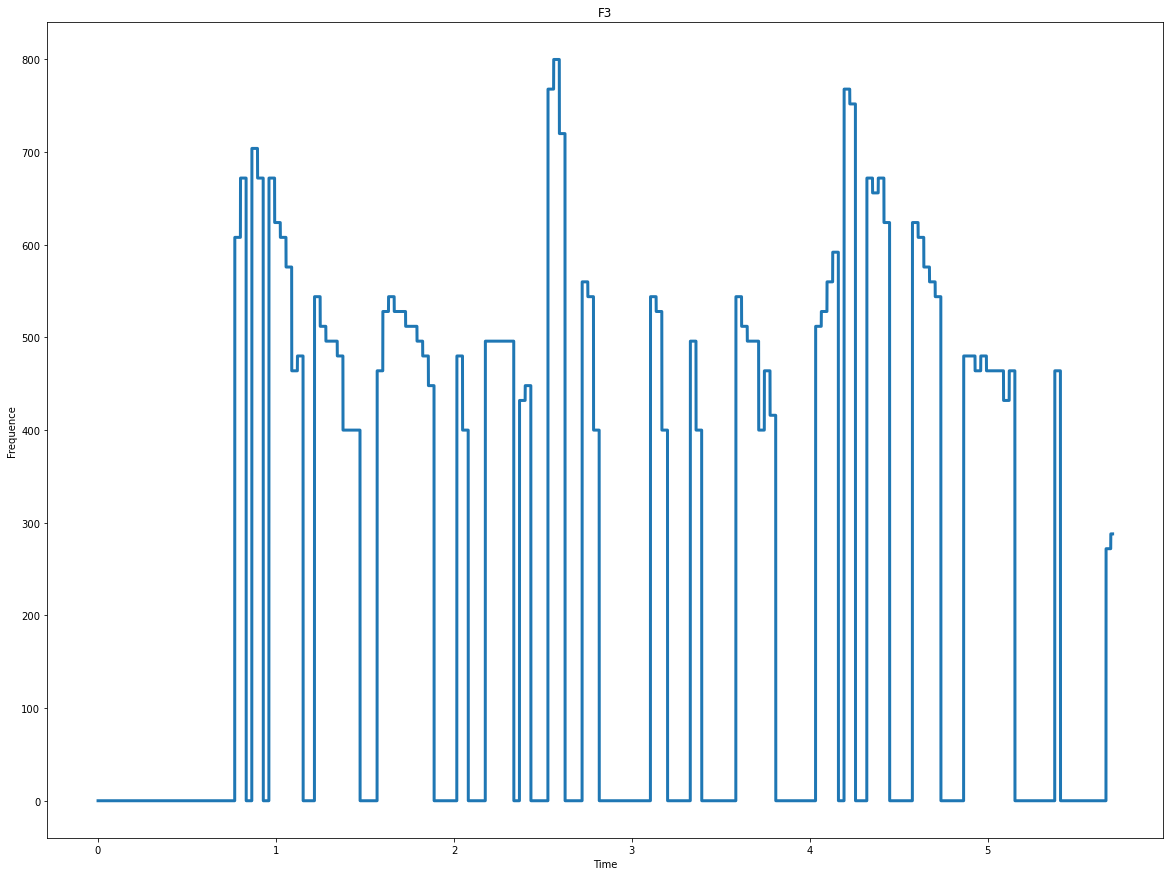

In [211]:
F3 = []

for i in range(len(amplitude)):
    if(frequences[i] != 0):
        nl1 = 4 * frequences[i] - segmentLength
        nu1 = 4 * frequences[i] + segmentLength
        array = amplitude[i][nl1:nu1]
        indexOfMax = np.argmax(array)
        nValue = amplitude[i][frequences[i]]
        if(array[indexOfMax] < 3*nValue):
            n0 = nl1 + indexOfMax
        else:
            n0 = 0
        for j in range(len(amplitude[i])):
            F3.append(n0 * Sr)
    else:
        for j in range(len(amplitude[i])):
            F3.append(0)
    
audio_time = len(F3) / samplerate
x = np.linspace(0, audio_time, len(F3))

plt.title('F3')
plt.ylabel("Frequence")
plt.xlabel("Time")
plt.plot(x, F3, linewidth = 3)
plt.show()

Строим сонограмму

Sonogram


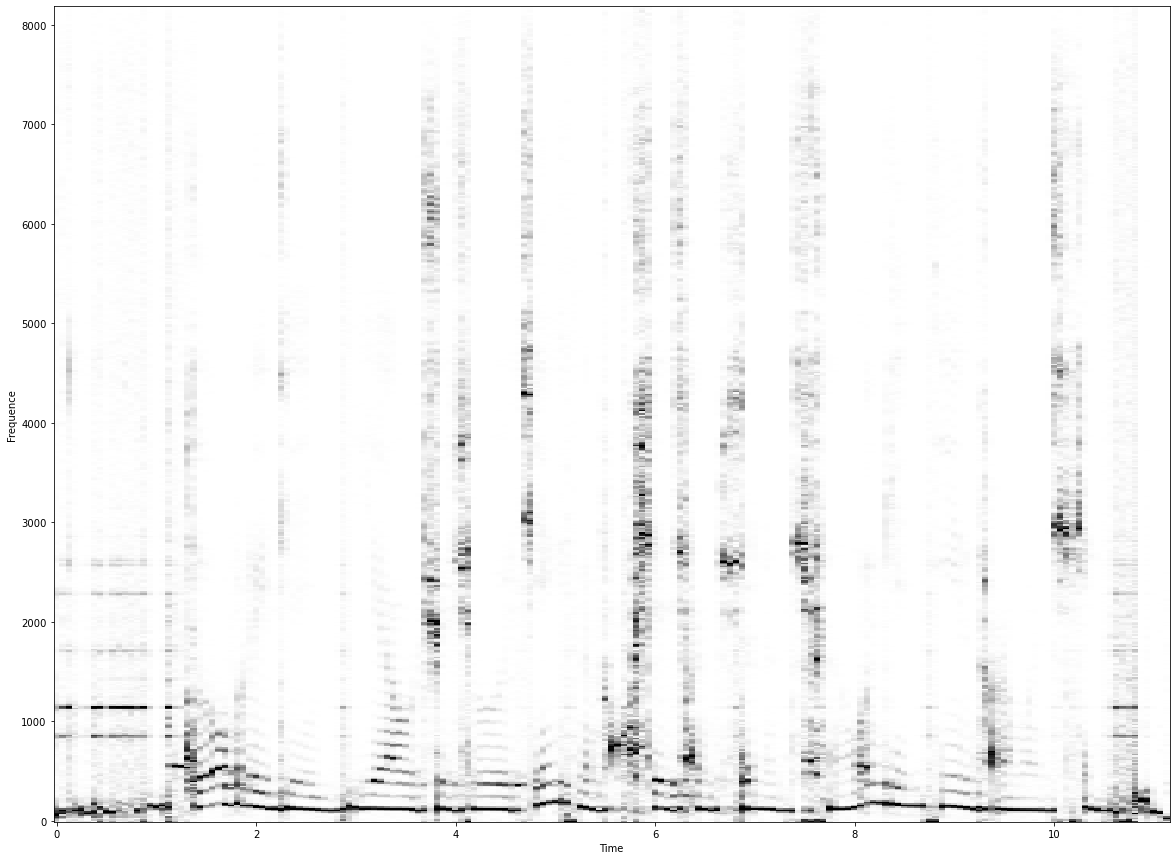

In [212]:
sonogram = np.zeros((N//2, len(amplitude)))

for i in range(len(amplitude)):
    Amax = np.max(amplitude[i])
    for j in range(len(amplitude[i])):
        if 50 > j * Sr > 40000:
            continue
        else:
            sonogram[j][i] = amplitude[i][j] / Amax
               
print("Sonogram")
plt.xlabel("Time")
plt.ylabel("Frequence")
audio_time = np.arange(len(sonogram[0])) / Sr
freq = np.arange(len(sonogram)) * Sr
plt.pcolormesh(audio_time, freq, sonogram, cmap = plt.cm.gray_r, shading='auto')
plt.show()
